In [1]:
%load_ext autoreload
%autoreload 2

# Analysing previous simulation

## Imports

In [2]:
from synbio_morpher.scripts.summarise_simulation.run_summarise_simulation import main as summarise
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:

config = {
    "experiment": {
        "purpose": "summarise_simulation"
    },
    "source_dirs": {
        "is_source_dir_incomplete": False,
        "source_dir": "data/tests/2023_10_25_205736",
        "purpose_to_get_source_dir_from": "",
        "source_dir_actually_used_POSTERITY": None
    },
    "preprocessing_func": None,
    "only_visualise_circuits": False,
    "interactions": {
        "binding_rates_association": 1000000
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}
config_file = expand_config(config=config)
config_file = prepare_config(config_file)
summarise(config)

In [4]:
fn = 'data/summarise_simulation/2023_10_26_094510/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

## Visualise

In [5]:
def readout(data, 
            sel_cols=None,
            log_opts=None):

    if sel_cols and (log_opts is None):
        log_opts = [(False, False)] * len(sel_cols)
        
    cols = flatten_listlike([[i for i in data.columns if (c in i) and (
        'ratio' not in i) and ('diff' not in i)] for c in sel_cols])

    nrows = np.ceil(np.sqrt(len(cols))).astype(int)
    ncols = np.ceil(np.sqrt(len(cols))).astype(int)
    fig = plt.figure(figsize=(6*ncols, 5*nrows))
    fig.subplots_adjust(hspace=0.3)
    for i, (s, c, l) in enumerate(zip(sel_cols, cols, log_opts)):
        ax = plt.subplot(nrows, ncols, i+1)
        sns.histplot(data, x=c, element='step', bins=150, log_scale=l)
        plt.title(prettify_keys_for_label(s))

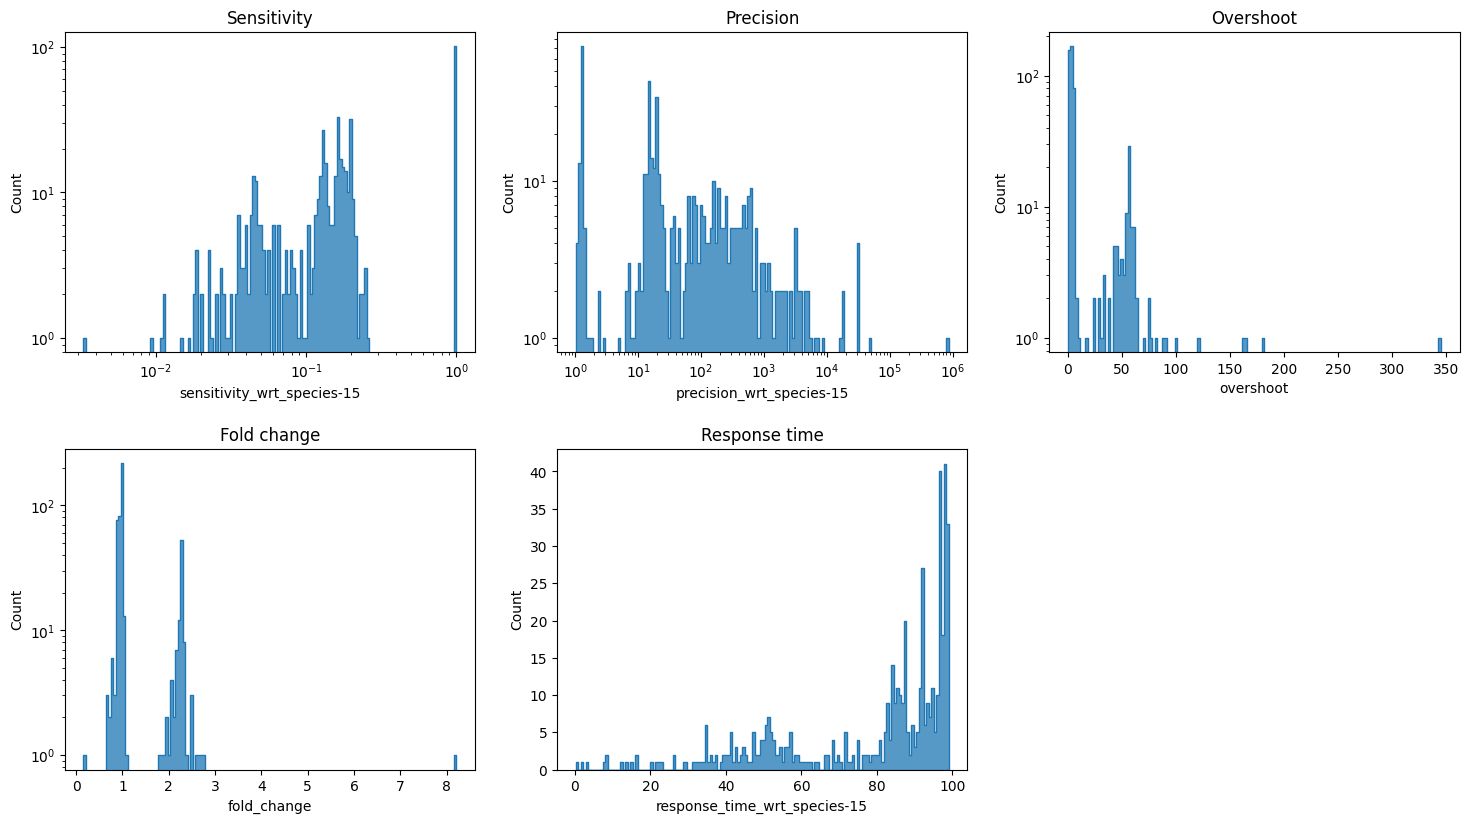

In [6]:
readout(data, 
        sel_cols=['sensitivity', 'precision', 'overshoot', 'fold_change', 'response_time'], 
        log_opts=[(True, True), (True, True), (False, True), (False, True), (False, False)])

### Interactions / Energies

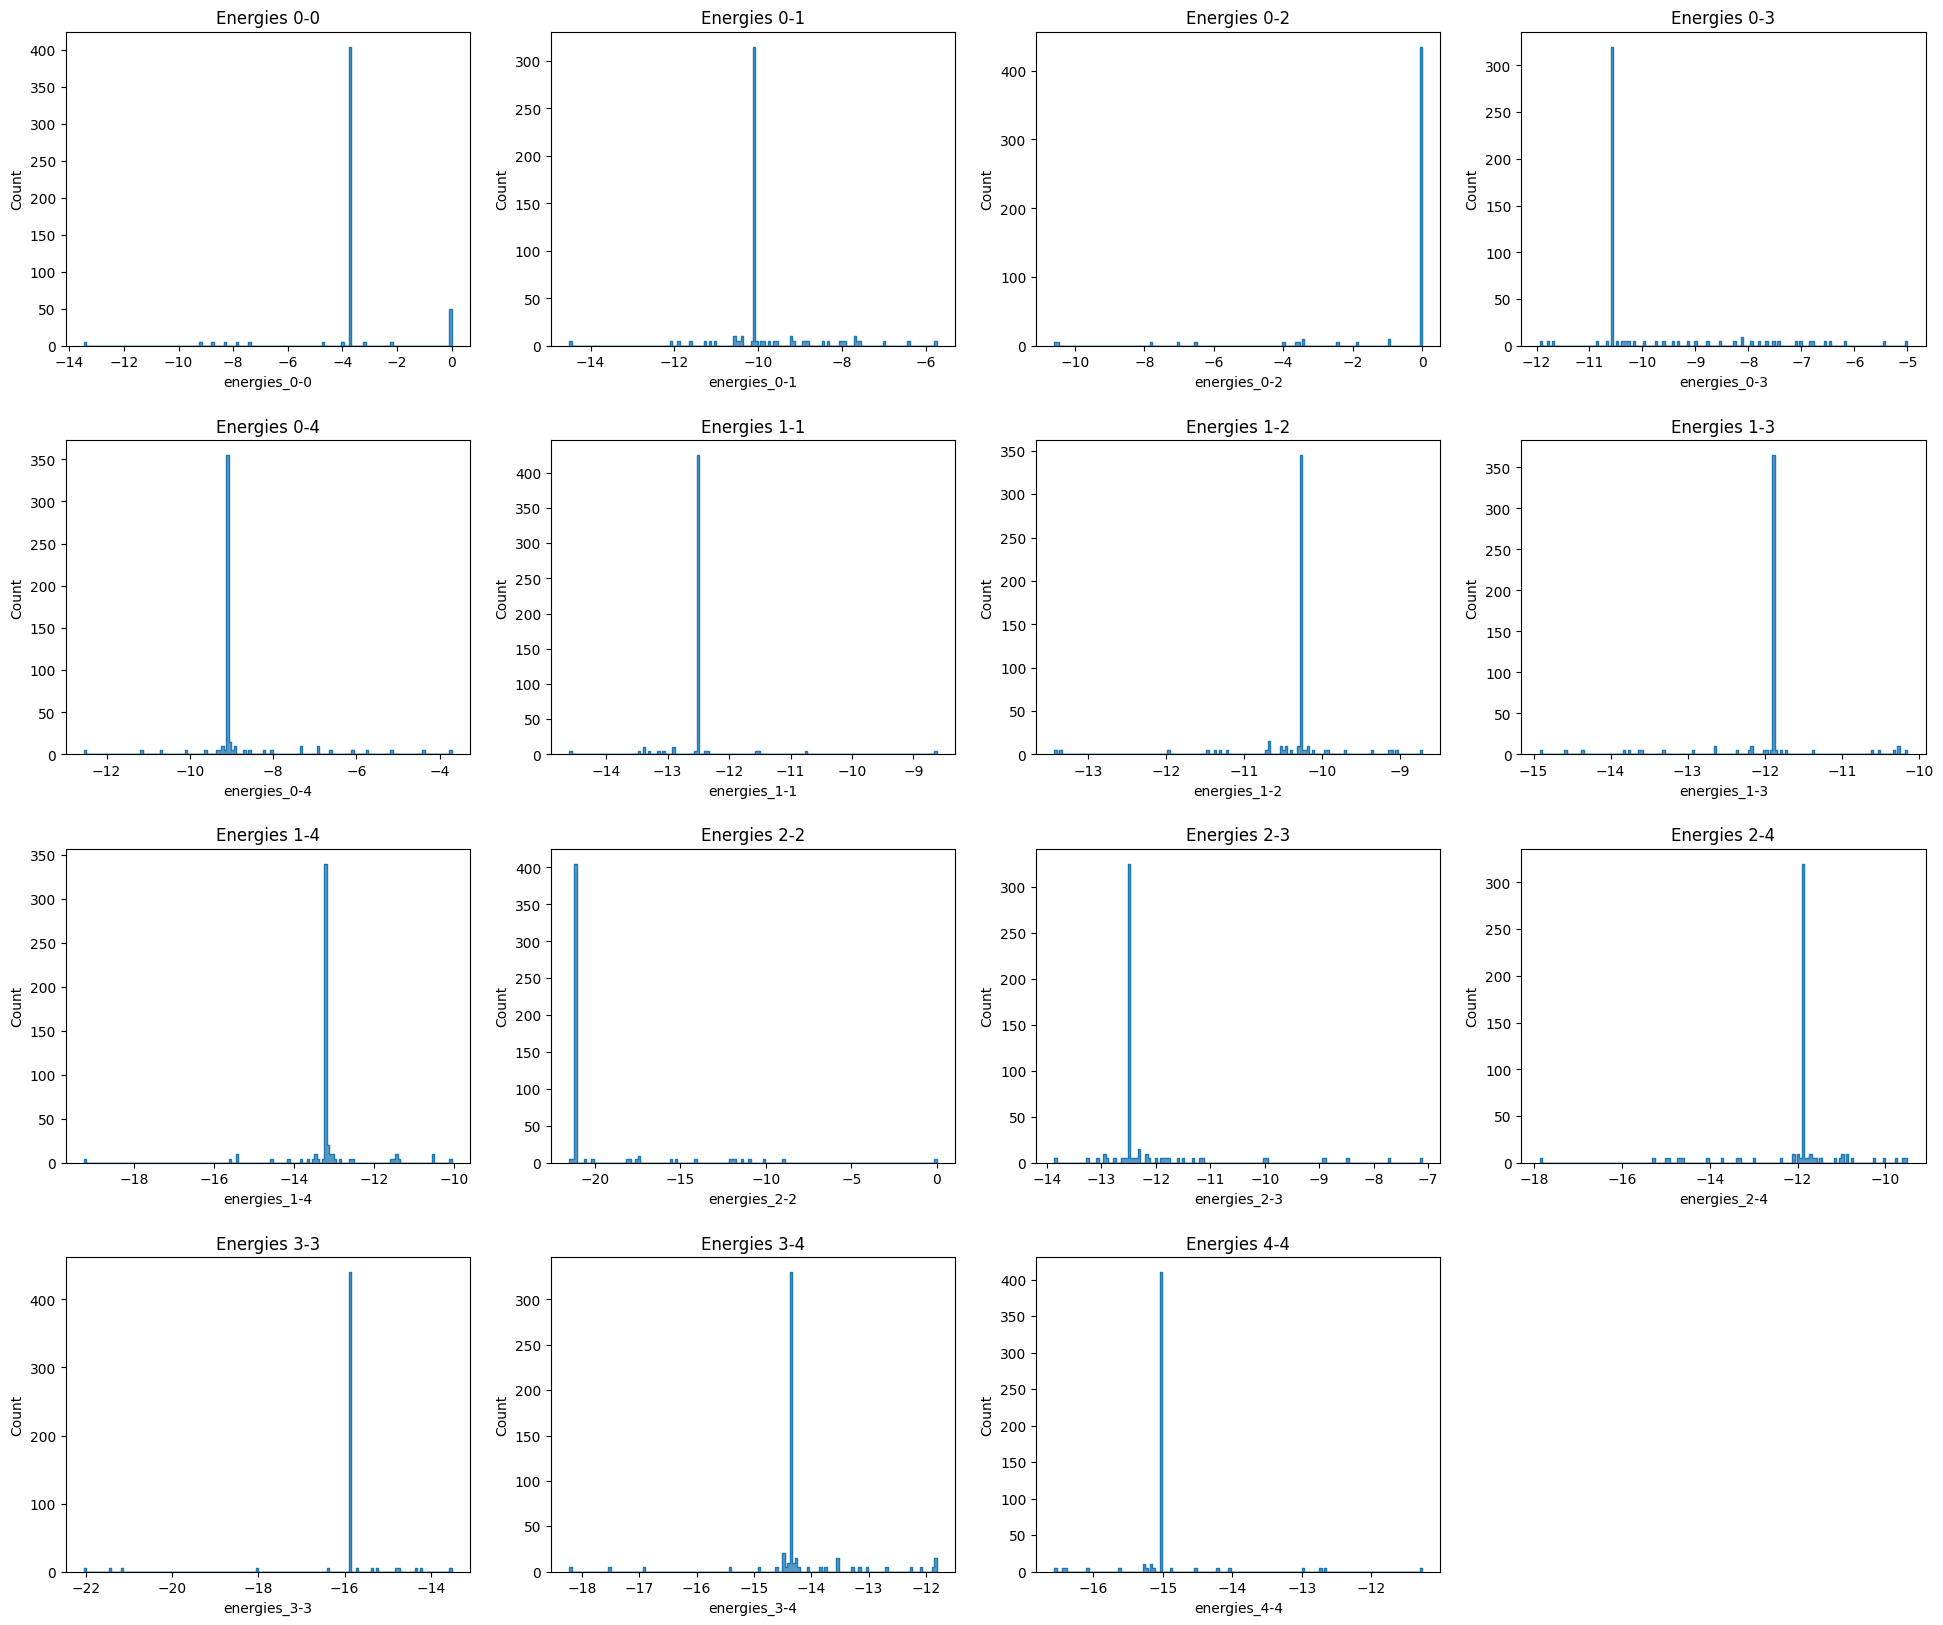

In [7]:
e_cols = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
readout(data, 
        sel_cols=e_cols)

Text(0.5, 0, 'Minimum free binding energy (kcal)')

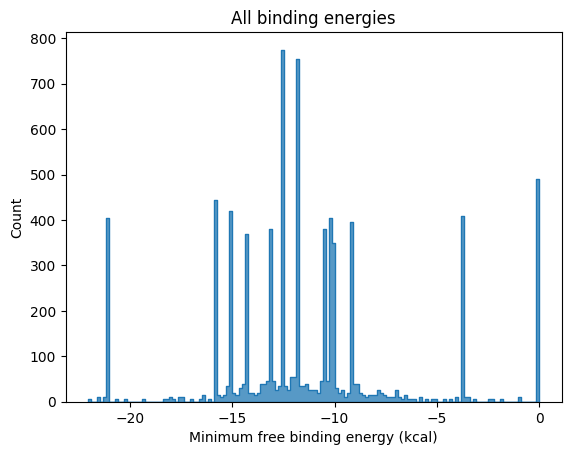

In [8]:
sns.histplot(data[e_cols].to_numpy().flatten(), element='step', bins=150)
plt.title('All binding energies')
plt.xlabel('Minimum free binding energy (kcal)')

### Sensitivity of each species to mutation

In [9]:
data.groupby(by=['sample_name'])['fold_change'].std()

sample_name
galK    0.608618
micA    0.092188
micC    0.038371
micF    0.044173
ryhB    0.037809
Name: fold_change, dtype: float64

In [10]:
data['sample_name'].unique()

array(['galK', 'micA', 'micC', 'micF', 'ryhB'], dtype=object)

In [17]:
samples_map = {i: s for i, s in zip(np.arange(
    len(data['sample_name'].unique())), sorted(data['sample_name'].unique()))}

# stds = {s: pd.DataFrame(columns= data['mutation_num'].unique()) for s in sorted(data['sample_name'].unique())}
# stds = pd.DataFrame()
stds = {}
for i, s in samples_map.items():
    es = [e for e in e_cols if str(i) in e]

    grouped_std = data.groupby(by=['mutation_num'])[es].std()
    stds[s] = grouped_std
    # grouped_std = np.where(grouped_std == 0, data.groupby(by=['mutation_num'])[
    #                        es].mean().abs(), grouped_std / data.groupby(by=['mutation_num'])[es].mean().abs())

stds

{'galK':               energies_0-0  energies_0-1  energies_0-2  energies_0-3  \
 mutation_num                                                           
 0                 0.000000      0.000000      0.000000      0.000000   
 1                 1.051047      0.875185      0.000000      1.190456   
 3                 1.658611      1.151597      0.781089      1.192742   
 5                 1.469580      0.773933      2.287534      1.254846   
 20                2.588719      1.457387      3.009464      1.852988   
 
               energies_0-4  
 mutation_num                
 0                 0.000000  
 1                 0.592663  
 3                 1.037357  
 5                 1.314471  
 20                1.340756  ,
 'micA':               energies_0-1  energies_1-1  energies_1-2  energies_1-3  \
 mutation_num                                                           
 0                 0.000000      0.000000      0.000000      0.000000   
 1                 0.875185      0.005902

In [16]:
grouped_std

,energies_0-4,energies_1-4,energies_2-4,energies_3-4,energies_4-4
mutation_num,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.592663,0.143235,1.038728,0.787744,0.494380
3,1.037357,0.534573,0.656525,0.211853,0.074686
5,1.314471,0.866859,1.494601,0.914127,0.831345
20,1.340756,1.616970,1.130182,1.240705,0.772945


In [13]:
data['mutation_num'].value_counts()

1     125
20    125
3     125
5     125
0       5
Name: mutation_num, dtype: int64